### CAA freshwater content

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from datetime import date
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import warnings
import seaborn as sns
from dateutil.relativedelta import relativedelta
warnings.filterwarnings('ignore')

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

cont_color = '#d67434' 
glac_color = '#0873b4'
ice_color  = '#9b9b9a'
land_color = '#a9a7a2'

##### Load files:

In [3]:
mesh  = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [4]:
CAA_glac, CAA_cont, CAA_ice = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/CAA_timeseries.pickle', 'rb'))
CAA_glac = np.array(CAA_glac)
CAA_cont = np.array(CAA_cont)
CAA_ice  = np.array(CAA_ice)

In [5]:
fCB_glac, fCB_cont, fCB_ice = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/full_CB_timeseries.pickle', 'rb'))
fCB_glac = np.array(fCB_glac)
fCB_cont = np.array(fCB_cont)
fCB_ice  = np.array(fCB_ice)

In [6]:
cCB_glac, cCB_cont, cCB_ice = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/central_CB_timeseries.pickle', 'rb'))
cCB_glac = np.array(cCB_glac)
cCB_cont = np.array(cCB_cont)
cCB_ice  = np.array(cCB_ice)

Add to time series plot:
- pacific water freshwater content
- freshwater content of model --- Hu et al (2019) see a general increase in Beaufort Gyre freshwater content from 2002-2017. Identify that "the changes in FWC are not directlycaused by PW rather than linked to the variations of atmospheric circulation and sea ice melting." 

"Budget analysis suggests that this difference in Beaufort Gyre freshwater storage is mainly caused by lateral advection. The lateral freshwater flux is decomposed into two components due to theslow-varying circulation and mesoscale eddies. "

In [21]:
FWC_dates  =  np.array([dt.datetime(year,1,1) for year in range(2002,2020)])

FWC_ANHA12 = np.array([15.7, 15, 15.5, 16.5, 16.7, 16.3, 18, 17.8, 17.9, 17.9, 18.5, 18, 18.2, \
                       18.4, 18.8, 19.2, np.nan, np.nan]) # from Hu et al. (2019)
FWC_observed = np.array([np.nan, 16.5, 16.8, 17.8, 18.3, 19.4, 21.4, 21.4, 21.4, 21.3, 21.5, \
                         20.2, 21, 21.8, 22.9, np.nan, np.nan, np.nan]) # in Hu et al. (2019)

In [12]:
rf = np.empty((19*12, imax-imin, jmax-jmin))
i  = 0
for year in range(2002, 2020):
    for month in range(0,12):
        c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y'+str(year)+'.nc','r')
        rf[i*12+month,:,:] = np.array(c.variables['runoff'])[month,imin:imax,jmin:jmax]
        
    i+=1

##### Functions:

In [8]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31,12)
    
    file_list1E = np.sort(os.listdir('/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

##### Calculations:

Create mask for CAA

In [9]:
mask_ini_CAA  = np.ones(lon.shape) # full domain size
mask_ini_CAA[0:imin+10, :] = 0 # remove the boundaries
mask_ini_CAA[imax-10:, :]  = 0
mask_ini_CAA[:, 0:jmin]    = 0
mask_ini_CAA[:, jmax-20:]  = 0

# Define CAA using the longitudes
mask_CAA = np.ma.masked_where((mesh_bathy > 800), mask_ini_CAA)
mask_CAA = np.ma.masked_where(lon < -130, mask_CAA)

mask_CAA_lons = np.ma.masked_where(mask_CAA==0, lon)
mask_CAA_lats = np.ma.masked_where(mask_CAA==0, lat)

mask_CAA_yr   = np.tile(mask_CAA[imin:imax,jmin:jmax], (73,50,1,1))

In [13]:
mask_CAA_rf = np.tile(mask_CAA[imin:imax,jmin:jmax], (228,1,1))
rf_dates    = np.array([dt.datetime(2002,1,1) + relativedelta(months=+i) for i in range(0,228)])
rf_CAA      = np.ma.sum(np.ma.masked_where(mask_CAA_rf==0, rf), axis=(1,2))

Mask for CB:

In [14]:
mask_ini_CB  = np.ones(lon.shape) # full domain size
mask_ini_CB[0:imin+10, :] = 0 # remove the boundaries
mask_ini_CB[imax-10:, :]  = 0
mask_ini_CB[:, 0:jmin]    = 0
mask_ini_CB[:, jmax-20:]  = 0

# Define Canada Basin using the 800 m contour and longitudes
# mask_CB = np.ma.masked_where((mesh_bathy < 800) & (lon > -150), mask_ini_CB)
mask_CB = np.ma.masked_where((mesh_bathy < 3200), mask_ini_CB)
mask_CB = np.ma.masked_where((lon > -80), mask_CB)

mask_CB_lons = np.ma.masked_where(mask_CB==0, lon)
mask_CB_lats = np.ma.masked_where(mask_CB==0, lat)

mask_CB_yr   = np.tile(mask_CB[imin:imax,jmin:jmax], (73,50,1,1))

In [15]:
mask_ini_fullCB  = np.ones(lon.shape) # full domain size
mask_ini_fullCB[0:imin+10, :] = 0 # remove the boundaries
mask_ini_fullCB[imax-10:, :]  = 0
mask_ini_fullCB[:, 0+10:jmin] = 0
mask_ini_fullCB[:, jmax-20:]  = 0

# Define fullCB using the longitudes
mask_fullCB = np.ma.masked_where((mesh_bathy < 800), mask_ini_fullCB)
mask_fullCB = np.ma.masked_where((lon > -60), mask_fullCB)
mask_fullCB = np.ma.masked_where((lon > -100) & (lat < 78), mask_fullCB)

mask_fullCB_lons = np.ma.masked_where(mask_fullCB==0, lon)
mask_fullCB_lats = np.ma.masked_where(mask_fullCB==0, lat)

mask_fullCB_yr   = np.tile(mask_fullCB[imin:imax,jmin:jmax], (73,50,1,1))

In [16]:
dates = np.array([file_dates(year) for year in range(2002,2020)]).flatten()

## Figures

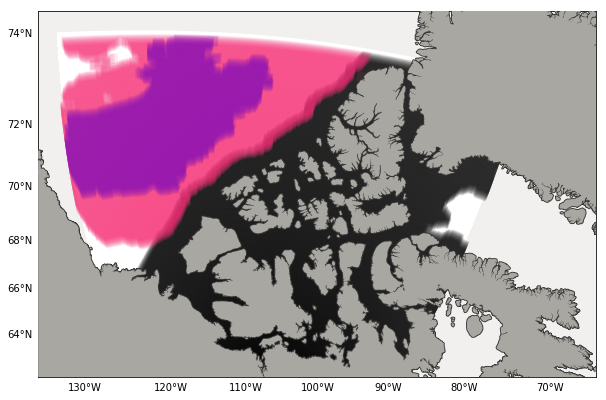

In [47]:
fig, ax1 = plt.subplots(figsize=(10,12))

# Map:
proj2 = Basemap(projection='stere',lat_0 = 77, lon_0 = -100, resolution='i', width=3.5e6, height=2.3e6, ax=ax1)
proj2.drawcoastlines(color='#373736', linewidth=1.8, zorder=5)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
proj2.drawparallels(np.arange(int(60),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=10)
proj2.drawmeridians(np.arange(int(-150),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=10)
x_land, y_land = proj2(lon, lat)
# proj2.contourf(x_land, y_land, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=4000, zorder=1)

# Draw domain boundaries:
proj2.plot(x_land[imax:-1,:] , y_land[imax:-1,:] , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[:,jmax:-1] , y_land[:,jmax:-1] , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[:,0:jmin]  , y_land[:,0:jmin]  , '-', color='#f1f0ee', linewidth=10, zorder=1);
proj2.plot(x_land[0:imin,:]  , y_land[0:imin,:]  , '-', color='#f1f0ee', linewidth=10, zorder=1);

### Region definitions ####
# CAA:
x_CAA, y_CAA = proj2(mask_CAA_lons, mask_CAA_lats)
proj2.plot(x_CAA, y_CAA, '-', color='k', linewidth=10, zorder=4, alpha=0.1);

# CB full-region:
x_CBf, y_CBf = proj2(mask_fullCB_lons, mask_fullCB_lats)
proj2.plot(x_CBf, y_CBf, '-', color='#f7347a', linewidth=10, zorder=4, alpha=0.1);

# CB sub-region:
x_CB, y_CB = proj2(mask_CB_lons, mask_CB_lats)
proj2.plot(x_CB, y_CB, '-', color='#8c15b9', linewidth=10, zorder=4, alpha=0.1);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R6-domain-definition.png', bbox_inches='tight', dpi=300)

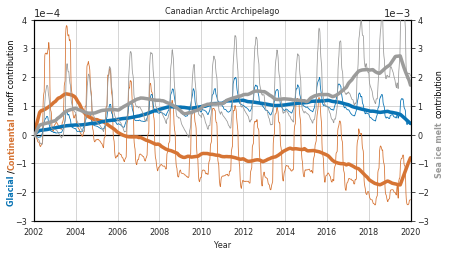

In [17]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

# Calculate difference from baseline:
cont = CAA_cont-CAA_cont[0]
ice  = CAA_ice-CAA_ice[0]
glac = CAA_glac-CAA_glac[0]

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=1.2)
    
    # Five day files: (thin lines)
    sns.lineplot(dates, cont, linewidth=0.8, color=cont_color, ax=ax)
    sns.lineplot(dates, glac, linewidth=0.8, color=glac_color, ax=ax)
  
    # Moving average 
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    glac_ave = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=cont_color, linewidth=3.5)
    sns.lineplot(dates[:], glac_ave, color=glac_color, linewidth=3.5)
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=8)
#     ax.set_ylabel('Contribution from            ',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_ylim(-3e-4,4e-4)
    ax.spines['left'].set_linewidth(1.2);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.2); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.2);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.2);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Canadian Arctic Archipelago', fontsize=8)
    
    ######## Sea ice axis ###################
    ax2 = ax.twinx()
    ax2.set_ylim(-3e-3, 4e-3)
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same') # Moving average
    sns.lineplot(dates, ice, linewidth=0.8, color=ice_color, ax=ax2)
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=ice_color , linewidth=3.5, ax=ax2)
    ax2.tick_params(axis='y', labelsize=8)
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax2.spines['left'].set_linewidth(0.0)
    ax2.spines['right'].set_linewidth(0.0)
    ax2.spines['bottom'].set_linewidth(0.0)
    ax2.spines['top'].set_linewidth(0.0)
    ax2.grid(False)
    
fig.text(0.95, 0.48, 'Sea ice melt ', fontsize=8, rotation='vertical', color=ice_color, weight='semibold')
fig.text(0.95, 0.67, 'contribution', fontsize=8, rotation='vertical')    
fig.text(0.07, 0.28, 'Glacial ', fontsize=8, rotation='vertical', color=glac_color, weight='semibold')
fig.text(0.07, 0.29, '/', fontsize=8, rotation='vertical', weight='semibold')
fig.text(0.07, 0.49, 'Continental', fontsize=8, rotation='vertical', color=cont_color, weight='semibold')
fig.text(0.07, 0.78, 'runoff contribution', fontsize=8, rotation='vertical')

figure = plt.gcf()
figure.set_size_inches(4.5*1.5, 3.7)
    
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-CAA-runoff.png', bbox_inches='tight',dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-CAA-runoff.svg', bbox_inches='tight',dpi=300, format='svg')

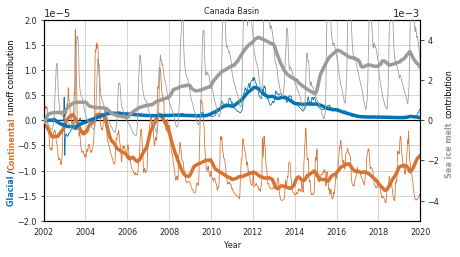

In [27]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

# Calculate difference from baseline:
cont = fCB_cont-fCB_cont[0]
ice  = fCB_ice-fCB_ice[0]
glac = fCB_glac-fCB_glac[0]

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=1.2)
    
    # Five day files: (thin lines)
    sns.lineplot(dates, cont, linewidth=0.8, color=cont_color, ax=ax)
    sns.lineplot(dates, glac, linewidth=0.8, color=glac_color, ax=ax)
  
    # Moving average 
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    glac_ave = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=cont_color, linewidth=3.5)
    sns.lineplot(dates[:], glac_ave, color=glac_color, linewidth=3.5)
  
#     # Freshwater content:
#     sns.scatterplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*1e-6, s=70, color='k', ax=ax)
#     sns.scatterplot(FWC_dates, (FWC_observed-FWC_observed[1])*1e-6, s=70, color='k', ax=ax)
#     sns.lineplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*1e-6, 
#                  linewidth=3.5, color='k', label=r'Freshwater content ANHA12', ax=ax)
#     sns.lineplot(FWC_dates, (FWC_observed-FWC_observed[1])*1e-6, \
#                  linewidth=3.5, color='k', label=r'Freshwater content observed', ax=ax)  
#     ax.lines[4].set_linestyle('-')
#     ax.lines[5].set_linestyle('--')
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_ylim(-2e-5,2e-5)
    ax.spines['left'].set_linewidth(1.2);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.2); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.2);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.2);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Canada Basin', fontsize=8)
    
    ######## Sea ice axis ###################
    ax2 = ax.twinx()
    ax2.set_ylim(-5e-3, 5e-3)
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same') # Moving average
    sns.lineplot(dates, ice, linewidth=0.8, color=ice_color, ax=ax2)
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=ice_color , linewidth=3.5, ax=ax2)
    ax2.tick_params(axis='y', labelsize=8)
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax2.spines['left'].set_linewidth(0.0)
    ax2.spines['right'].set_linewidth(0.0)
    ax2.spines['bottom'].set_linewidth(0.0)
    ax2.spines['top'].set_linewidth(0.0)
    ax2.grid(False)
    
fig.text(0.95, 0.48, 'Sea ice melt ', fontsize=8, rotation='vertical', color=ice_color, weight='semibold')
fig.text(0.95, 0.67, 'contribution', fontsize=8, rotation='vertical')    
fig.text(0.05, 0.28, 'Glacial ', fontsize=8, rotation='vertical', color=glac_color, weight='semibold')
fig.text(0.05, 0.29, '/', fontsize=8, rotation='vertical', weight='semibold')
fig.text(0.05, 0.49, 'Continental', fontsize=8, rotation='vertical', color=cont_color, weight='semibold')
fig.text(0.05, 0.78, 'runoff contribution', fontsize=8, rotation='vertical')

figure = plt.gcf()
figure.set_size_inches(4.5*1.5, 3.7)
    
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-fCB-runoff.png', bbox_inches='tight',dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-fCB-runoff.svg', bbox_inches='tight',dpi=300, format='svg')

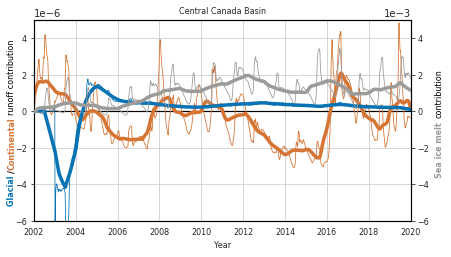

In [28]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

# Calculate difference from baseline:
cont = cCB_cont-cCB_cont[0]
ice  = cCB_ice-cCB_ice[0]
glac = cCB_glac-cCB_glac[0]

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=1.2)
    
    # Five day files: (thin lines)
    sns.lineplot(dates, cont, linewidth=0.8, color=cont_color, ax=ax)
    sns.lineplot(dates, glac, linewidth=0.8, color=glac_color, ax=ax)
  
    # Moving average 
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    glac_ave = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=cont_color, linewidth=3.5)
    sns.lineplot(dates[:], glac_ave, color=glac_color, linewidth=3.5)
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_ylim(-6e-6,5e-6)
    ax.spines['left'].set_linewidth(1.2);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.2); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.2);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.2);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Central Canada Basin', fontsize=8)
    
    ######## Sea ice axis ###################
    ax2 = ax.twinx()
    ax2.set_ylim(-6e-3, 5e-3)
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same') # Moving average
    sns.lineplot(dates, ice, linewidth=0.8, color=ice_color, ax=ax2)
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=ice_color , linewidth=3.5, ax=ax2)
    ax2.tick_params(axis='y', labelsize=8)
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax2.spines['left'].set_linewidth(0.0)
    ax2.spines['right'].set_linewidth(0.0)
    ax2.spines['bottom'].set_linewidth(0.0)
    ax2.spines['top'].set_linewidth(0.0)
    ax2.grid(False)
    
fig.text(0.95, 0.48, 'Sea ice melt ', fontsize=8, rotation='vertical', color=ice_color, weight='semibold')
fig.text(0.95, 0.67, 'contribution', fontsize=8, rotation='vertical')    
fig.text(0.07, 0.28, 'Glacial ', fontsize=8, rotation='vertical', color=glac_color, weight='semibold')
fig.text(0.07, 0.29, '/', fontsize=8, rotation='vertical', weight='semibold')
fig.text(0.07, 0.49, 'Continental', fontsize=8, rotation='vertical', color=cont_color, weight='semibold')
fig.text(0.07, 0.78, 'runoff contribution', fontsize=8, rotation='vertical')
    
figure = plt.gcf()
figure.set_size_inches(4.5*1.5, 3.7)
    
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-cCB-runoff.png', bbox_inches='tight',dpi=300)
figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper2/D1-cCB-runoff.svg', bbox_inches='tight',dpi=300, format='svg')

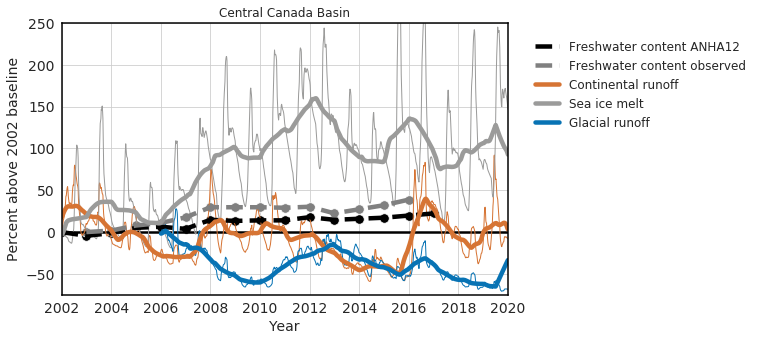

In [23]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

cont = np.array(cCB_cont - cCB_cont[0])*100/cCB_cont[0]
ice  = np.array(cCB_ice - cCB_ice[0])*100/cCB_ice[0]
skip_yrs = 4*73
glac = np.array(cCB_glac[skip_yrs:] - cCB_glac[skip_yrs])*100/np.abs(cCB_glac[skip_yrs])

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=2.5)
    
    # Continental Runoff and sea ice melt
    sns.lineplot(dates,            cont, linewidth=1, color=cont_color, ax=ax)
    sns.lineplot(dates,             ice, linewidth=1, color=ice_color , ax=ax)
    sns.lineplot(dates[skip_yrs:], glac, linewidth=1, color=glac_color, ax=ax)
  
    # Freshwater content:
    sns.scatterplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], s=90, \
                   color='k', ax=ax)
    sns.scatterplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], s=90, \
                    color='gray', ax=ax)
    sns.lineplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], \
                 linewidth=4.5, color='k', label=r'Freshwater content ANHA12', ax=ax)
    sns.lineplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], \
                 linewidth=4.5, color='gray', label=r'Freshwater content observed', ax=ax)  
    ax.lines[4].set_linestyle('--')
    ax.lines[5].set_linestyle('--')

    # Moving average
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same')
    glac_ave  = np.convolve(glac, np.ones((N,))/N, mode='same')
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, \
                 color=cont_color, linewidth=4.5, label=r'Continental runoff')
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, \
                 color=ice_color , linewidth=4.5, label=r'Sea ice melt')
    sns.lineplot(dates[skip_yrs:], glac_ave, \
                 color=glac_color, linewidth=4.5, label=r'Glacial runoff')
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent above 2002 baseline',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set(ylim=(-75,250))
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Central Canada Basin')
    leg  = ax.legend(loc=(1.05, 0.59), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R5-cCB-runoff-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

In [ ]:
fig = plt.figure(figsize=(8,5))
st  = sns.axes_style("whitegrid")

cont = np.array(ts_cont - ts_cont[0])*100/ts_cont[0]
ice  = np.array(ts_ice - ts_ice[0])*100/ts_ice[0]
skip_yrs = 0*73
glac = np.array(ts_glac[skip_yrs:] - ts_glac[skip_yrs])*100/np.abs(ts_glac[skip_yrs])

with st:
    
    ax = sns.lineplot([dates[0], dates[-1]], [0, 0], c='k', linewidth=2.5)
    
    # Continental Runoff and sea ice melt
    sns.lineplot(dates, cont, linewidth=1, color=ccont, ax=ax)
    sns.lineplot(dates, ice, linewidth=1, color=cice, ax=ax)
    sns.lineplot(dates[skip_yrs:], glac, linewidth=1, color=cglac, ax=ax)
  
    # Freshwater content:
    sns.scatterplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], s=90, \
                   color='k', ax=ax)
    sns.scatterplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], s=90, \
                    color='gray', ax=ax)
    sns.lineplot(FWC_dates, (FWC_ANHA12-FWC_ANHA12[0])*100/FWC_ANHA12[0], \
                 linewidth=4.5, color='k', label=r'Freshwater content ANHA12', ax=ax)
    sns.lineplot(FWC_dates, (FWC_observed-FWC_observed[1])*100/FWC_observed[1], \
                 linewidth=4.5, color='gray', label=r'Freshwater content observed', ax=ax)  
    ax.lines[4].set_linestyle('--')
    ax.lines[5].set_linestyle('--')

    # Moving average
    N = 73
    cont_ave = np.convolve(cont, np.ones((N,))/N, mode='same')
    ice_ave  = np.convolve(ice , np.ones((N,))/N, mode='same')
    glac_ave = np.convolve(glac, np.ones((N,))/N, mode='same') # moving average
    sns.lineplot(dates[len(cont)-len(cont_ave):], cont_ave, color=ccont, linewidth=4.5, label=r'Continental runoff')
    sns.lineplot(dates[len(ice) -len(ice_ave):], ice_ave, color=cice, linewidth=4.5, label=r'Sea ice melt')
    sns.lineplot(dates[skip_yrs:], glac_ave, color=cglac, linewidth=4.5, label=r'Glacial runoff')
    
    # Other figure settings
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Percent above 2002 baseline',fontsize=14)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set(ylim=(-75,250))
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    ax.set_title('Canada Basin')
    leg  = ax.legend(loc=(1.05, 0.59), frameon=True, framealpha=0.7, fontsize=12)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R5-fullCB-runoff-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)